In [ ]:
  !pip install pymysql
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 12.8 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=62aeb5832f81f431ef5173669e59df32972968f0bc3133c69bc61ade5c876738
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
import pandas as pd
import pymysql
import numpy as np
import emoji
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def extract_emojis(text):
    for c in text:
        if c in emoji.UNICODE_EMOJI['en']:
          text = re.sub(c, "", text)
    
    return text

# 함수 정의 1 (자모로 분해)
NO_JONGSUNG = 'ᴕ'

CHOSUNGS = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
JOONGSUNGS = ['ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
JONGSUNGS = [NO_JONGSUNG,  'ㄱ', 'ㄲ', 'ㄳ', 'ㄴ', 'ㄵ', 'ㄶ', 'ㄷ', 'ㄹ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅁ', 'ㅂ', 'ㅄ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']

N_CHOSUNGS = 19
N_JOONGSUNGS = 21
N_JONGSUNGS = 28

FIRST_HANGUL = 0xAC00 #'가'
LAST_HANGUL = 0xD7A3 #'힣'

def to_jamo(s):        
    result = []
    for c in s:
        if ord(c) < FIRST_HANGUL or ord(c) > LAST_HANGUL: # if a character is a hangul
            result.append(c)
        else:            
            code = ord(c) - FIRST_HANGUL
            jongsung_index = code % N_JONGSUNGS
            code //= N_JONGSUNGS
            joongsung_index = code % N_JOONGSUNGS
            code //= N_JOONGSUNGS
            chosung_index = code

            result.append(CHOSUNGS[chosung_index])
            result.append(JOONGSUNGS[joongsung_index])
            result.append(JONGSUNGS[jongsung_index])
    
    return ''.join(result) 


def bunhae(s):
    return [to_jamo(i) for i in s]

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 {} 이하인 샘플의 비율: {}'.format(max_len, (cnt / len(nested_list))*100))

def sentiment_predict(new_sentence):
    new_sentence = list("".join(bunhae(new_sentence)))
    encoded0 = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded0, maxlen = 100) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 부정 문장입니다.\n".format(score * 100))
    else:    
        print("{:.2f}% 확률로 긍정 문장입니다.\n".format((1 - score) * 100))

In [ ]:
con = pymysql.connect(
    user='study',
    passwd='hellobee1234',
    host='121.134.135.223',
    port=3306,
    db='data'
)
cur = con.cursor()

sql="SELECT * FROM dataset"
cur.execute(sql)
rows = cur.fetchall()
con.close()

df=pd.DataFrame(rows)
df.columns=['records','label']
df=df.dropna(how='any')
df['records'] = df['records'].map(extract_emojis)
df['records'] = df['records'].str.replace(r'\[\d+\]', "")
df=df.dropna(how='any')
df.drop_duplicates(subset=['records'], inplace=True)
df['records'] = df['records'].str.replace("\xa0", "")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.


[['ㅇㅣᴕ', 'ㄱㅓᴕ', ' ', 'ㅈㅣㄴ', 'ㅉㅏᴕ', ' ', 'ㅂㅕㅇ', 'ㅅㅣㄴ', 'ㄱㅏㅌ', 'ㄴㅔᴕ'], ['ㅅㅔᴕ', 'ㅊㅔᴕ', 'ㄱㅕㄴ', ' ', 'ㅍㅔᴕ', 'ㅇㅣᴕ', 'ㅋㅓㄹ']]
[['ㅇㅣᴕㄱㅓᴕ ㅈㅣㄴㅉㅏᴕ ㅂㅕㅇㅅㅣㄴㄱㅏㅌㄴㅔᴕ'], ['ㅅㅔᴕㅊㅔᴕㄱㅕㄴ ㅍㅔᴕㅇㅣᴕㅋㅓㄹ']]
[['ㅇ', 'ㅣ', 'ᴕ', 'ㄱ', 'ㅓ', 'ᴕ', ' ', 'ㅈ', 'ㅣ', 'ㄴ', 'ㅉ', 'ㅏ', 'ᴕ', ' ', 'ㅂ', 'ㅕ', 'ㅇ', 'ㅅ', 'ㅣ', 'ㄴ', 'ㄱ', 'ㅏ', 'ㅌ', 'ㄴ', 'ㅔ', 'ᴕ'], ['ㅅ', 'ㅔ', 'ᴕ', 'ㅊ', 'ㅔ', 'ᴕ', 'ㄱ', 'ㅕ', 'ㄴ', ' ', 'ㅍ', 'ㅔ', 'ᴕ', 'ㅇ', 'ㅣ', 'ᴕ', 'ㅋ', 'ㅓ', 'ㄹ']]
리뷰의 최대 길이 : 354
리뷰의 평균 길이 : 43.906796219042086


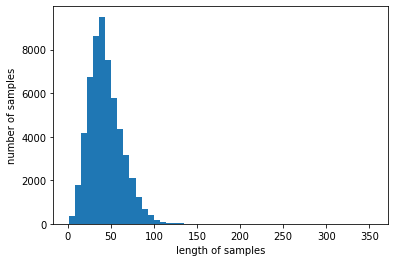

전체 샘플 중 길이가 100 이하인 샘플의 비율: 99.41560613261517


In [ ]:
result1=[]
for i in range(len(df)):
    result1.append(bunhae(df.iloc[i,0]))
print(result1[:2])

result2=[]
for i in range(len(df)):
    result2.append(bunhae(["".join(df.iloc[i,0])]))
print(result2[:2])

result3=[]
for i in range(len(df)):
    result3.append(list(result2[i][0]))
print(result3[:2])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(result3)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(result3)

with open('jamolstm.pkl', 'wb') as f:
	pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(word2idx) + 1 

max_len = 100
below_threshold_len(max_len, encoded)

encoded = pad_sequences(encoded, maxlen = max_len)

X_train, X_valid, y_train, y_valid = train_test_split(encoded, df['label'], test_size=0.2, random_state=123)

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(100, dropout=0.6))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(patience=4,restore_best_weights=True)
mc = ModelCheckpoint('./model/test1.h5', save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=16, validation_split=0.2)

from tensorflow.keras.models import load_model
loaded_model = load_model('./model/test1.h5')

print("테스트 정확도: {:.4f}".format(loaded_model.evaluate(X_valid, y_valid)[1]))

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(100, dropout=0.6))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(patience=4,restore_best_weights=True)
mc = ModelCheckpoint('./model/test1.h5', save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, callbacks=[es, mc], batch_size=128, validation_split=0.2)

from tensorflow.keras.models import load_model
loaded_model = load_model('./model/test1.h5')

print("테스트 정확도: {:.4f}".format(loaded_model.evaluate(X_valid, y_valid)[1]))

Epoch 1/100
285/285 [==============================] - 40s 136ms/step - loss: 0.5459 - accuracy: 0.7239 - val_loss: 0.5158 - val_accuracy: 0.7466
Epoch 2/100
285/285 [==============================] - 38s 134ms/step - loss: 0.4919 - accuracy: 0.7662 - val_loss: 0.4749 - val_accuracy: 0.7743
Epoch 3/100
285/285 [==============================] - 38s 133ms/step - loss: 0.4578 - accuracy: 0.7878 - val_loss: 0.4418 - val_accuracy: 0.7959
Epoch 4/100
285/285 [==============================] - 38s 132ms/step - loss: 0.4286 - accuracy: 0.8055 - val_loss: 0.4148 - val_accuracy: 0.8241
Epoch 5/100
285/285 [==============================] - 38s 133ms/step - loss: 0.3933 - accuracy: 0.8283 - val_loss: 0.3881 - val_accuracy: 0.8330
Epoch 6/100
285/285 [==============================] - 38s 133ms/step - loss: 0.3637 - accuracy: 0.8445 - val_loss: 0.3341 - val_accuracy: 0.8641
Epoch 7/100
285/285 [==============================] - 38s 133ms/step - loss: 0.3426 - accuracy: 0.8580 - val_loss: 0.3103 -

In [ ]:
sentiment_predict(')

99.12% 확률로 부정 문장입니다.

